In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORT LIBRARIES/DATASETS

In [2]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import Model, load_model, Sequential
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [3]:
datafolder = "/content/drive/MyDrive/FY Project/data2"
os.chdir("/content/drive/MyDrive/FY Project")

In [4]:
# Check the number of images in the dataset
data = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('data2', i))
  for j in train_class:
    img = os.path.join('data2', i, j)
    data.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(data)))


Number of train images : 3672 



# PERFORM DATA EXPLORATION AND DATA VISUALIZATION

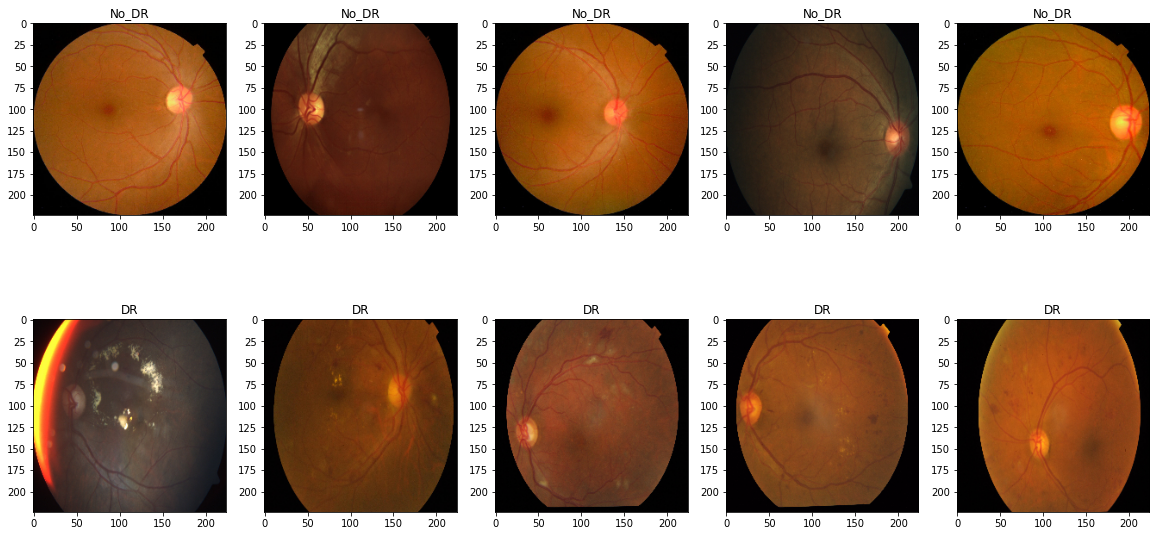

In [5]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(2, 5, figsize = (20, 10))
count = 0
for i in os.listdir(datafolder):
  # get the list of images in a given class
  train_class = os.listdir(os.path.join('data2', i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('data2', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1



In [6]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
total = 0;
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('data2', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))
  total+=len(train_class)  
print("\n\tNumber of total images = {}".format(total))

Number of images in No_DR = 1815 

Number of images in DR = 1857 


	Number of total images = 3672


In [7]:
retina_df = pd.DataFrame({'Image': data,'Labels': label})
retina_df

,Image,Labels
0,data2/No_DR/780f9daaa24b.png,No_DR
1,data2/No_DR/726dff37edc0.png,No_DR
2,data2/No_DR/73d40ce06a67.png,No_DR
3,data2/No_DR/7a12f49e29df.png,No_DR
4,data2/No_DR/780be525036d.png,No_DR
...,...,...
3667,data2/DR/6363b360aefb.png,DR
3668,data2/DR/7247a2c97f71.png,DR
3669,data2/DR/657859f893d9.png,DR
3670,data2/DR/760b6f4c6d82.png,DR


# PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [26]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.3, random_state = 42)

In [27]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split = 0.15)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)

In [28]:
# Creating datagenerator for training, validation and test dataset.
train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2185 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.


# BUILD RES-BLOCK BASED DEEP LEARNING MODEL

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate

In [ ]:
# Create an inception Block
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
#GoogleNet Function
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (256, 256, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 2
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 2, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)


  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (2,2), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.6)(X)

  # output layer 
  X = Dense(2, activation = 'softmax')(X)
  
  # model
  model_gn = Model(input_layer, X, name = 'GoogLeNet')

  return model_gn

In [ ]:
model = GoogLeNet()
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 125, 125, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 62, 62, 64)  0           ['conv2d_171[0][0]']             
 )                                                                                        

# COMPILE AND TRAIN DEEP LEARNING MODEL

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])

In [ ]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=50)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/FY Project/Saved Models/final_googlenet_binary.h5", verbose = 1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 100, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5093
Epoch 1: val_loss improved from inf to 0.69302, saving model to /content/drive/MyDrive/FY Project/Saved Models/final_googlenet_binary.h5
71/71 [==============================] - 49s 646ms/step - loss: 0.6933 - accuracy: 0.5093 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5240
Epoch 2: val_loss improved from 0.69302 to 0.69085, saving model to /content/drive/MyDrive/FY Project/Saved Models/final_googlenet_binary.h5
71/71 [==============================] - 46s 654ms/step - loss: 0.6936 - accuracy: 0.5240 - val_loss: 0.6908 - val_accuracy: 0.5234
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.6705
Epoch 3: val_loss did not improve from 0.69085
71/71 [==============================] - 45s 635ms/step - loss: 0.6168 - accuracy: 0.6705 - val_loss: 0.7770 - val_accuracy: 0

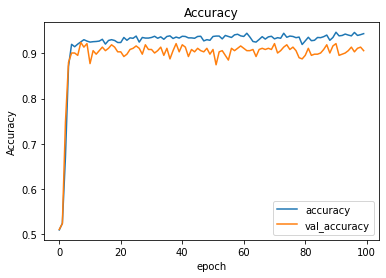

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'], loc = 'lower right')
plt.show()

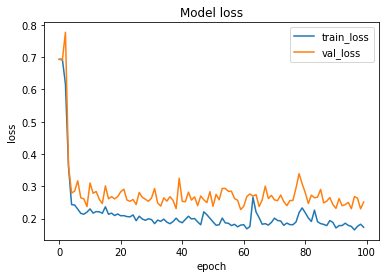

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# ASSESS THE PERFORMANCE OF THE TRAINED MODEL

In [29]:
# Evaluate the performance of the model
from keras.models import load_model
saved_model = load_model("/content/drive/MyDrive/FY Project/Final Models/final_googlenet_binary.h5")
evaluate = saved_model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

34/34 [==============================] - 95s 3s/step - loss: 0.1861 - accuracy: 0.9384


In [30]:
print('Accuracy Test : {:.4f} %'.format(evaluate[1]*100))
print('Loss Test : {:.4f}'.format(evaluate[0]))

Accuracy Test : 93.8419 %
Loss Test : 0.1861


In [31]:
# Assigning label names to the corresponding indexes
labels = {0: 'DR', 1: 'No_DR'}

In [32]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = saved_model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


1/1 [==============================] - 0s 19ms/step


In [33]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {:.4f} %".format(score*100))

Test Accuracy : 94.0109 %


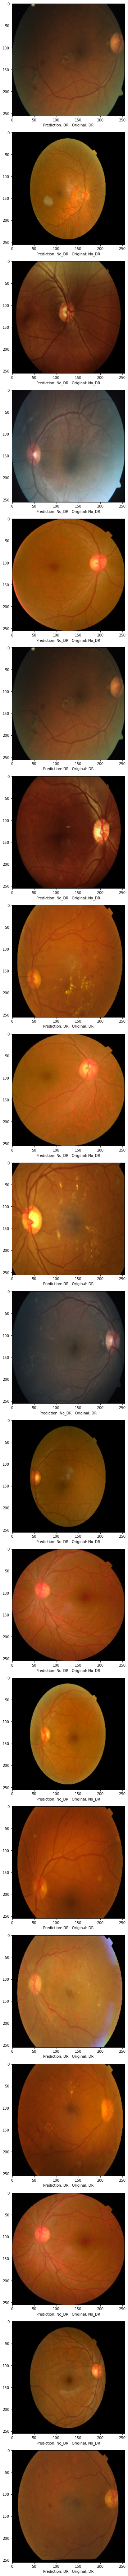

In [34]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import roc_curve,auc
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

          DR       0.95      0.93      0.94       556
       No_DR       0.93      0.95      0.94       546

    accuracy                           0.94      1102
   macro avg       0.94      0.94      0.94      1102
weighted avg       0.94      0.94      0.94      1102



Text(0.5, 1.0, 'Confusion_matrix')

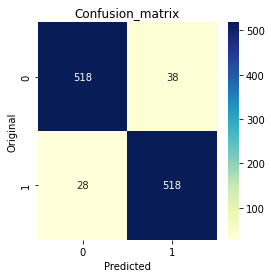

In [38]:
import seaborn as sns
plt.figure(figsize = (4,4))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu", fmt='g')

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

In [39]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
sensitivity = (TP/(TP + FN))
specificity = (TN/(TN + FP))

print("Sensitivity : "+str(sensitivity))
print("Specificity : "+str(specificity))


Sensitivity : [0.93165468 0.94871795]
Specificity : [0.94871795 0.93165468]


In [40]:
from sklearn.metrics import roc_auc_score
list1=[]
list2=[]

for i in original:
  if(i == "DR"):
    list1.append(1)
  else:
    list1.append(0)
for i in prediction:
  if(i == "DR"):
    list2.append(1)
  else:
    list2.append(0)

auc = roc_auc_score(list1,list2)
print('ROC AUC: %.3f' % auc)

ROC AUC: 0.940


In [41]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(list1,list2)
print('Cohens Kappa: %.3f' % kappa)

Cohens Kappa: 0.880
